### Homework #7: Recurrent Neural Networtks (RNN) & Long Short-Term Memory (LSTM)
#### Luke Schwenke
#### Machine Learning & Predictive Analytics 
#### May 20, 2023

In [64]:
import sys
import os
import json
import pandas
import numpy
import optparse
import keras
import pandas as pd
import matplotlib.pyplot as plt

from keras.callbacks import TensorBoard
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, SimpleRNN
from keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from collections import OrderedDict
from keras import backend as k
from sklearn.model_selection import train_test_split
from keras import regularizers
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers import Bidirectional

In [2]:
dataframe = pandas.read_csv("dev-access.csv", engine='python', quotechar='|', header=None)

In [3]:
dataset = dataframe.values
dataset.shape

(26773, 2)

Store all rows and the 0th index as the feature data

In [4]:
X = dataset[:,0]

Store all rows and index 1 as the target variable

In [5]:
Y = dataset[:,1]
Y = Y.astype(int) # Need to convert from object to int

In the next step, we will clean up the predictors. This includes removing features that are not valuable, such as timestamp and source. 

In [6]:
for index, item in enumerate(X):
    # Quick hack to space out json elements
    reqJson = json.loads(item, object_pairs_hook=OrderedDict)
    del reqJson['timestamp']
    del reqJson['headers']
    del reqJson['source']
    del reqJson['route']
    del reqJson['responsePayload']
    X[index] = json.dumps(reqJson, separators=(',', ':'))

We next will tokenize our data, which just means vectorizing our text. Given the data we will tokenize every character (thus char_level = True)

In [7]:
tokenizer = Tokenizer(filters='\t\n', char_level=True)
tokenizer.fit_on_texts(X)

# we will need this later
num_words = len(tokenizer.word_index)+1
X = tokenizer.texts_to_sequences(X)

Need to pad our data as each observation has a different length

In [8]:
max_log_length = 1024
X_processed = pad_sequences(X, maxlen=max_log_length)

Create your train set to be 75% of the data and your test set to be 25%

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X_processed, Y, test_size=.25, random_state=0)

## Model #1: RNN

The first model will be a pretty minimal RNN with only an embedding layer, simple RNN and Dense layer. The next model we will add a few more layers.

In [10]:
k.clear_session()
model = Sequential()

From there, add an Embedding layer: https://keras.io/layers/embeddings/Links to an external site.

Params:
- input_dim = num_words (the variable we created above)
- output_dim = 32
- input_length = max_log_length (we also created this above)
- Keep all other variables as the defaults (shown below)

In [11]:
model.add(Embedding(input_dim=num_words, 
                    output_dim=32, 
                    input_length=max_log_length))

Add a SimpleRNN layer: https://keras.io/layers/recurrent/Links to an external site.

Params:
- units = 32
- activation = 'relu'

In [12]:
model.add(SimpleRNN(units=32, 
                    activation='relu'))

Finally, we will add a Dense layer: https://keras.io/layers/core/#denseLinks to an external site.

Params:
- units = 1 (this will be our output)
- activation --> you can choose to use either relu or sigmoid. 

In [13]:
model.add(Dense(units=1, 
                activation="relu"))

Compile model using the .compile() method: https://keras.io/models/model/Links to an external site.

Params:
- loss = binary_crossentropy
- optimizer = adam
- metrics = accuracy

In [14]:
model.compile(optimizer="adam", 
              loss="binary_crossentropy", 
              metrics=['acc'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1024, 32)          2016      
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,129
Trainable params: 4,129
Non-trainable params: 0
_________________________________________________________________


In [16]:
model_fit_1 = model.fit(X_train, Y_train, 
                        validation_split=.25, 
                        epochs=3, 
                        batch_size=128)

Epoch 1/3
118/118 [==============================] - 19s 153ms/step - loss: 0.9474 - acc: 0.5301 - val_loss: 0.5797 - val_acc: 0.6456
Epoch 2/3
118/118 [==============================] - 18s 149ms/step - loss: 0.5707 - acc: 0.6794 - val_loss: 0.7154 - val_acc: 0.5143
Epoch 3/3
118/118 [==============================] - 18s 149ms/step - loss: 0.6513 - acc: 0.6044 - val_loss: 0.6171 - val_acc: 0.6279


Use the .evaluate() method to get the loss value & the accuracy value on the test data. Use a batch size of 128 again.

In [17]:
model.evaluate(X_test, Y_test, batch_size=128)

53/53 [==============================] - 2s 35ms/step - loss: 0.6192 - acc: 0.6309


[0.6191905736923218, 0.6308634877204895]

## Model #2: LSTM + Dropout Layers

Now we will add a few new layers to our RNN and incorporate the more powerful LSTM. You will be creating a new model here, so make sure to call it something different than the model from Part 2.

This RNN needs to have the following layers (add in this order):

- Embedding Layer (use same params as before)
- LSTM Layer (units = 64, recurrent_dropout = 0.5)
- Dropout Layer - use a value of 0.5
- Dense Layer - (use same params as before)

In [18]:
k.clear_session()

model2 = Sequential()

model2.add(Embedding(input_dim=num_words, 
                    output_dim=32, 
                    input_length=max_log_length))

model2.add(LSTM(units=64, 
                recurrent_dropout=0.5))

model2.add(Dropout(0.5))

model2.add(Dense(units=1, 
                 activation="relu"))

In [19]:
model2.compile(optimizer="adam", 
               loss="binary_crossentropy", 
               metrics=["acc"])

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1024, 32)          2016      
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 26,913
Trainable params: 26,913
Non-trainable params: 0
_________________________________________________________________


In [20]:
model_fit_2 = model2.fit(X_train, Y_train, 
                         validation_split=.25, 
                         epochs=3, 
                         batch_size=128)

Epoch 1/3
118/118 [==============================] - 144s 1s/step - loss: 0.7696 - acc: 0.5739 - val_loss: 0.4760 - val_acc: 0.7309
Epoch 2/3
118/118 [==============================] - 152s 1s/step - loss: 0.5709 - acc: 0.7340 - val_loss: 0.4315 - val_acc: 0.8311
Epoch 3/3
118/118 [==============================] - 155s 1s/step - loss: 0.7094 - acc: 0.6552 - val_loss: 0.5967 - val_acc: 0.6305


In [21]:
model2.evaluate(X_test, Y_test, batch_size=128)

53/53 [==============================] - 9s 165ms/step - loss: 0.6001 - acc: 0.6277


[0.6001400947570801, 0.6277263164520264]

## Model #3: Custom RNN

RNN Requirements:
- Use 5 or more layers
- Add a layer that was not utilized in Model 1 or Model 2 (Note: This could be a new Dense layer or an additional LSTM)

In [22]:
k.clear_session()

model3 = Sequential()

model3.add(Embedding(input_dim=num_words, 
                     output_dim=32, 
                     input_length=max_log_length))

model3.add(LSTM(units=64, 
                recurrent_dropout=0.5))

model3.add(Dropout(0.5))

model3.add(Dense(units=1, 
                 activation="sigmoid"))

model3.add(Dense(units=64,
                 activation='relu',
                 kernel_regularizer=regularizers.l2(0.01)))

model3.add(Dense(units=1,
                 activation='sigmoid'))

In [23]:
model3.compile(optimizer="sgd", 
               loss="binary_crossentropy", 
               metrics=["acc", "mse"])

model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1024, 32)          2016      
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 dense_1 (Dense)             (None, 64)                128       
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 27,106
Trainable params: 27,106
Non-traina

In [24]:
model_fit_3 = model3.fit(X_train, Y_train, 
                         validation_split=.25, 
                         epochs=5, 
                         batch_size=128)

Epoch 1/5
118/118 [==============================] - 163s 1s/step - loss: 0.7113 - acc: 0.4998 - mse: 0.2500 - val_loss: 0.7110 - val_acc: 0.4916 - val_mse: 0.2500
Epoch 2/5
118/118 [==============================] - 163s 1s/step - loss: 0.7105 - acc: 0.5024 - mse: 0.2500 - val_loss: 0.7102 - val_acc: 0.4916 - val_mse: 0.2500
Epoch 3/5
118/118 [==============================] - 163s 1s/step - loss: 0.7097 - acc: 0.5024 - mse: 0.2500 - val_loss: 0.7093 - val_acc: 0.4916 - val_mse: 0.2500
Epoch 4/5
118/118 [==============================] - 164s 1s/step - loss: 0.7089 - acc: 0.5008 - mse: 0.2500 - val_loss: 0.7086 - val_acc: 0.4916 - val_mse: 0.2500
Epoch 5/5
118/118 [==============================] - 169s 1s/step - loss: 0.7082 - acc: 0.5024 - mse: 0.2500 - val_loss: 0.7079 - val_acc: 0.4916 - val_mse: 0.2500


In [25]:
model3.evaluate(X_test, Y_test, batch_size=128)

53/53 [==============================] - 10s 181ms/step - loss: 0.7078 - acc: 0.5048 - mse: 0.2500


[0.7078143954277039, 0.5047804117202759, 0.24998421967029572]

## Concepts

#### Explain the difference between the relu activation function and the sigmoid activation function.

* The **Rectified Linear Unit (ReLU) function** is defined as the positive part of its input, i.e., for input x, the function returns max(0, x). This means that ReLU is zero when x is less than zero, and x when x is greater than or equal to zero. The advantage of Relu is it is efficient because it can be implemented by thresholding a matrix of activations at 0. It also helps mitigate vanishing gradients where the gradients get smaller as they are passed back through layers of backpropagation. One issue with ReLU is that it can cause dead neurons, i.e., neurons that are not activated and therefore do not learn, especially when the learning rate is set too high. This is known as the "dying ReLU" problem.


* The **Sigmoid function** maps an input value between the range 0 and 1. This is useful for use in the last layer of a binary classification network where the output can be interpreted as the probability of class 1. The advantages are the outputs are bounded easily between 0 and 1 making it interpretable. The function can also be differentiated anywhere which is useful for gradient-based optimization. This function can suffer from vanishing gradients which can make the network refuse to learn further or be too slow to be useful during the backpropagation phase. Also, sigmoid does not zero-center the outputs which might make optimization harder.


#### Describe what one epoch actually is (epoch was a parameter used in the .fit() method).

* **An epoch refers to one complete pass through the entire training dataset while training a model**. With a method like gradient descent, this means that every example in your training dataset has had a chance to update the model's weights. After one epoch, the algorithm will have learned patterns from the entire dataset, but usually, multiple epochs are necessary to sufficiently train the model, especially on larger datasets. The number of epochs set is basically the number of times this learning cycle will be repeated.

#### Explain how dropout works (you can look at the keras code and/or documentation) for (a) training, and (b) test data sets.

* When training with dropout, during each batch of training, **some number of layer outputs are randomly ignored or "dropped out"**, meaning they're set to zero. In Keras, dropout is implemented as a separate layer that can be added to the neural network. When the dropout layer is specified with a rate of 0.2, it means approximately 20% of the input units to that layer will be dropped out during training. This helps prevent overfitting.

* **Dropping out is only done during training**. When evaluating the network on Test or use it to make predictions, the dropout layer is ignored and all neurons are used. However, the impact of dropout during training is that the network becomes less sensitive to the specific weights of neurons.

#### Explain why problems such as this homework assignment are better modeled with RNNs than CNNs. What type of problem will CNNs outperform RNNs on?

* Since this dataset includes time-series data from a log-file, the task is best suited for RNNs given they are able to store memory and provide feedback loops that allow information to be passed from one step in the sequence to the next. **This temporal (sequence-like) behavior makes the CNN's useful for tasks like this where the context and order are important.**


* CNN's are strong at handling spatial hierarchies and structures in data, which makes them superior RNN's for tasks that primarily involving image or video processing (image classification, object detection, image segmentation). They excel at these tasks because they are designed to automatically and adaptively learn spatial hierarchies of features from the input data, leveraging local connectivity and weight sharing. This means **CNN's can learn to recognize patterns like edges, shapes, and textures** in images that are important for distinguishing between different objects or classes.

#### Explain what RNN problem is solved using LSTM and briefly describe how.

* **RNNs face problems when dealing with long sequences of data with the vasishing gradient problem**. This issue arises during the training process, where the gradient - the value used to update the network's weights - becomes vanishingly small as it is propagated back through time. As a result, **the weights for earlier layers (those responsible for learning from earlier parts of the sequence) are hardly updated, meaning the network struggles to learn and maintain information over long sequences.**

* Long Short-Term Memory units (LSTMs), a special kind of RNN, are designed to combat this problem by introducing a concept of a "cell state," a kind of conveyor belt that runs through the top of the LSTM unit, **allowing information to flow through the network unimpeded by the transformations happening in the rest of the unit**. Additionally, LSTMs have a set of "gates" (input, forget, and output gates) that control the flow of information into and out of the cell state. These gates are neural networks themselves and decide what information gets remembered, what gets added to the cell state, and what gets output. **These mechanisms allow LSTMs to effectively learn and remember information over long sequences, mitigating the vanishing gradient problem** and making them well-suited for tasks involving long-term dependencies.

## Time Series with LSTMs

Import, clean and plot the input data

In [46]:
h = pd.read_csv('DAYTON_hourly.csv')

In [47]:
h.head(10)

,Datetime,DAYTON_MW
0,2004-12-31 01:00:00,1596.0
1,2004-12-31 02:00:00,1517.0
2,2004-12-31 03:00:00,1486.0
3,2004-12-31 04:00:00,1469.0
4,2004-12-31 05:00:00,1472.0
5,2004-12-31 06:00:00,1518.0
6,2004-12-31 07:00:00,1598.0
7,2004-12-31 08:00:00,1691.0
8,2004-12-31 09:00:00,1748.0
9,2004-12-31 10:00:00,1825.0


In [48]:
h.shape

(121275, 2)

Train test split (use helper function)

In [49]:
import pandas as pd
import numpy as np
from typing import Tuple


def create_data_for_NN(
    data: pd.DataFrame, Y_var: str, lag: int, test_ratio: float
) -> Tuple[np.array, np.array, np.array, np.array]:
    """Function to return lagged time series data after train-test split

    Args:
        data (pd.DataFrame): Raw time series data frame
        Y_var (str): String with the name of y variable
        lag (int): number of lagged records to consider
        test_ratio (float): ratio of data to consider for test set

    Returns:
        Tuple[np.array, np.array, np.array, np.array]: Lagged and split numpy arrays
    """
    y = data[Y_var].tolist()

    X, Y = [], []

    if len(y) - lag <= 0:
        X.append(y)
    else:
        for i in range(len(y) - lag):
            Y.append(y[i + lag])
            X.append(y[i : (i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an LSTM input shape
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # Creating training and test sets
    X_train = X
    X_test = []

    Y_train = Y
    Y_test = []

    if test_ratio > 0:
        index = round(len(X) * test_ratio)
        X_train = X[: (len(X) - index)]
        X_test = X[-index:]

        Y_train = Y[: (len(X) - index)]
        Y_test = Y[-index:]

    return X_train, X_test, Y_train, Y_test


#### Fit a single layer LSTM with lag = 3 hours

In [50]:
k.clear_session()

lag = 3
test_ratio = 0.15

data = pd.read_csv("DAYTON_hourly.csv")
data.Datetime = pd.to_datetime(data.Datetime)
data.sort_values(by="Datetime", inplace=True)

X_train, X_test, Y_train, Y_test = create_data_for_NN(
    data, data.columns[-1], lag, test_ratio
)

In [51]:
time_model_1 = Sequential()
time_model_1.add(LSTM(units=64, activation='relu'))
time_model_1.add(Dense(units=1))

time_model_1.compile(loss='mean_squared_error', optimizer='adam')

In [52]:
time_model_1.fit(X_train, Y_train, epochs=10, batch_size=128)

Epoch 1/10
806/806 [==============================] - 3s 2ms/step - loss: 235373.7969
Epoch 2/10
806/806 [==============================] - 2s 2ms/step - loss: 4301.1553
Epoch 3/10
806/806 [==============================] - 2s 2ms/step - loss: 9948.6455
Epoch 4/10
806/806 [==============================] - 2s 2ms/step - loss: 4199.9097
Epoch 5/10
806/806 [==============================] - 2s 2ms/step - loss: 4057.0693
Epoch 6/10
806/806 [==============================] - 2s 2ms/step - loss: 3935.1521
Epoch 7/10
806/806 [==============================] - 2s 2ms/step - loss: 3775.2422
Epoch 8/10
806/806 [==============================] - 2s 2ms/step - loss: 3672.0737
Epoch 9/10
806/806 [==============================] - 2s 2ms/step - loss: 3431.5989
Epoch 10/10
806/806 [==============================] - 2s 2ms/step - loss: 3445.6973


In [53]:
print('\nRMSE of Single Layer LSTM with Lag 3 Hours =', 
      np.sqrt(time_model_1.evaluate(X_test, Y_test, batch_size=128)))

143/143 [==============================] - 0s 1ms/step - loss: 2342.8857

RMSE of Single Layer LSTM with Lag 3 Hours = 48.403364988268116


#### Fit a single layer LSTM with lag = 24 hours

In [54]:
k.clear_session()

lag = 24
test_ratio = 0.15

data = pd.read_csv("DAYTON_hourly.csv")
data.Datetime = pd.to_datetime(data.Datetime)
data.sort_values(by="Datetime", inplace=True)

X_train, X_test, Y_train, Y_test = create_data_for_NN(
    data, data.columns[-1], lag, test_ratio
)

In [55]:
time_model_2 = Sequential()
time_model_2.add(LSTM(units=64, activation='relu'))
time_model_2.add(Dense(units=1))

time_model_2.compile(loss='mean_squared_error', optimizer='adam')

In [56]:
time_model_2.fit(X_train, Y_train, epochs=10, batch_size=128)

Epoch 1/10
806/806 [==============================] - 10s 11ms/step - loss: 2668156.7500
Epoch 2/10
806/806 [==============================] - 9s 11ms/step - loss: 64471.8242
Epoch 3/10
806/806 [==============================] - 10s 12ms/step - loss: 49855.3867
Epoch 4/10
806/806 [==============================] - 10s 12ms/step - loss: 36417.0273
Epoch 5/10
806/806 [==============================] - 10s 12ms/step - loss: 37463.4883
Epoch 6/10
806/806 [==============================] - 10s 13ms/step - loss: 68124.9766
Epoch 7/10
806/806 [==============================] - 10s 13ms/step - loss: 43383.4727
Epoch 8/10
806/806 [==============================] - 11s 13ms/step - loss: 32626.7871
Epoch 9/10
806/806 [==============================] - 11s 13ms/step - loss: 28258.9414
Epoch 10/10
806/806 [==============================] - 11s 13ms/step - loss: 29712.3906


In [57]:
print('\nRMSE of Single Layer LSTM with Lag 24 Hours =', 
      np.sqrt(time_model_2.evaluate(X_test, Y_test, batch_size=128)))

143/143 [==============================] - 1s 6ms/step - loss: 26928.1152

RMSE of Single Layer LSTM with Lag 24 Hours = 164.0978830892556


#### Fit a Bidirectional layer LSTM with lag = 24 hours

In [58]:
k.clear_session()

In [59]:
time_model_3 = Sequential()
time_model_3.add(Bidirectional(LSTM(units=64, activation='relu')))
time_model_3.add(Dense(units=1))

time_model_3.compile(loss='mean_squared_error', optimizer='adam')

In [60]:
time_model_3.fit(X_train, Y_train, epochs=10, batch_size=128)

Epoch 1/10
806/806 [==============================] - 18s 20ms/step - loss: 597620.0625
Epoch 2/10
806/806 [==============================] - 16s 20ms/step - loss: 31191.4062
Epoch 3/10
806/806 [==============================] - 16s 20ms/step - loss: 20429.1348
Epoch 4/10
806/806 [==============================] - 16s 20ms/step - loss: 12513.9297
Epoch 5/10
806/806 [==============================] - 17s 20ms/step - loss: 9520.5664
Epoch 6/10
806/806 [==============================] - 17s 21ms/step - loss: 7178.2935
Epoch 7/10
806/806 [==============================] - 17s 20ms/step - loss: 5231.4673
Epoch 8/10
806/806 [==============================] - 17s 21ms/step - loss: 4171.1421
Epoch 9/10
806/806 [==============================] - 17s 21ms/step - loss: 3825.0071
Epoch 10/10
806/806 [==============================] - 17s 21ms/step - loss: 6390.2573


In [62]:
print('\nRMSE of Bidirectional Layer LSTM with Lag 24 Hours =', 
      np.sqrt(time_model_3.evaluate(X_test, Y_test, batch_size=128)))

143/143 [==============================] - 1s 6ms/step - loss: 4885.8027

RMSE of Bidirectional Layer LSTM with Lag 24 Hours = 69.8985173975457


#### Results

The best performing time series LSTM model was the **Single Layer LSTM with a Lag of 3 hours**. This model had an **RMSE of 48.4** compared to the Single Layer 24-hour Lag LSTM's RMSE of 164.1 and the Bidirectional Layer 24-hour Lag LSTM's RMSE of 69.8. Overall we can conclude that the Single Layer LSTM with the 3-hour lag captures the patterns in the time series dataset best.

In [68]:
preds_time_1 = time_model_1.predict(X_test, batch_size=128)
preds_time_2 = time_model_2.predict(X_test, batch_size=128)
preds_time_3 = time_model_3.predict(X_test, batch_size=128)

143/143 [==============================] - 1s 6ms/step


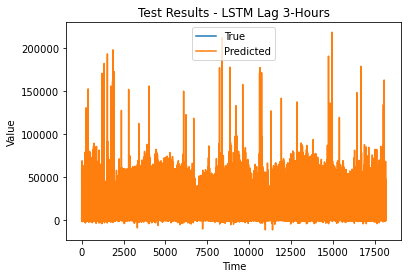

In [78]:
plt.plot(Y_test, label='True')
plt.plot(preds_time_1, label='Predicted')
plt.title('Test Results - LSTM Lag 3-Hours')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

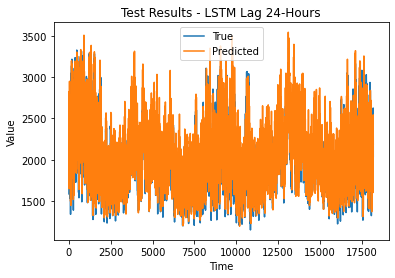

In [79]:
plt.plot(Y_test, label='True')
plt.plot(preds_time_2, label='Predicted')
plt.title('Test Results - LSTM Lag 24-Hours')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

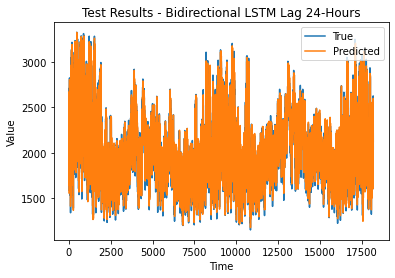

In [80]:
plt.plot(Y_test, label='True')
plt.plot(preds_time_3, label='Predicted')
plt.title('Test Results - Bidirectional LSTM Lag 24-Hours')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()